<a href="https://colab.research.google.com/github/ushio2580/Gradient2/blob/main/6x6Maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# version 2

In [1]:
# Import necessary libraries
import gym
from gym import spaces
import numpy as np
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt
import argparse
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Define the maze environment
class MazeEnv(gym.Env):
    def __init__(self):
        super(MazeEnv, self).__init__()
        # 6x6 maze: 0=free space, 1=wall, 2=start, 3=goal
        self.maze = np.array([
            [2, 0, 0, 0, 0, 0],
            [1, 1, 0, 1, 1, 0],
            [0, 0, 0, 0, 0, 0],
            [0, 1, 1, 1, 0, 1],
            [0, 0, 0, 0, 0, 0],
            [0, 1, 0, 1, 1, 3]
        ])
        self.start_pos = (0, 0)  # Starting position
        self.end_pos = (5, 5)    # Goal position
        self.agent_pos = self.start_pos
        self.max_steps = 100     # Max steps per episode
        self.current_step = 0
        self.action_space = spaces.Discrete(4)  # Actions: 0=up, 1=right, 2=down, 3=left
        self.observation_space = spaces.Tuple((spaces.Discrete(6), spaces.Discrete(6)))

    def reset(self):
        """Reset the environment to the initial state."""
        self.agent_pos = self.start_pos
        self.current_step = 0
        return self.agent_pos

    def step(self, action):
        """Take a step in the environment based on the action."""
        self.current_step += 1
        row, col = self.agent_pos
        # Define possible movements
        if action == 0 and row > 0:      # Up
            new_pos = (row - 1, col)
        elif action == 1 and col < 5:    # Right
            new_pos = (row, col + 1)
        elif action == 2 and row < 5:    # Down
            new_pos = (row + 1, col)
        elif action == 3 and col > 0:    # Left
            new_pos = (row, col - 1)
        else:
            new_pos = self.agent_pos  # Invalid move, no position change

        # Check if the move is valid (not a wall)
        if self.maze[new_pos] != 1:
            self.agent_pos = new_pos

        # Determine reward and done status
        if self.agent_pos == self.end_pos:
            reward = 1.0
            done = True
        elif self.current_step >= self.max_steps:
            reward = -0.1
            done = True
        else:
            reward = -0.1
            done = False
        return self.agent_pos, reward, done, {}

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size=2, action_size=4):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)  # Increase memory capacity
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.1           # Higher minimum epsilon
        self.epsilon_decay = 0.999       # Slower decay
        self.learning_rate = 0.01        # Higher learning rate
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        """Build a larger neural network."""
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, input_dim=self.state_size, activation='relu'),  # Larger layer
            tf.keras.layers.Dense(64, activation='relu'),                            # Larger layer
            tf.keras.layers.Dense(self.action_size, activation='linear', dtype='float32')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def update_target_model(self):
        """Update the target model's weights."""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """Store an experience in memory."""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Choose an action based on exploration or exploitation."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploration
        state = np.array(state).reshape(1, -1)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])  # Exploitation

    def replay(self, batch_size):
        """Train the model with a sample from memory."""
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states = np.array([t[0] for t in minibatch])
        next_states = np.array([t[3] for t in minibatch])
        targets = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = reward if done else reward + self.gamma * np.max(next_q_values[i])
            targets[i][action] = target
        self.model.fit(states, targets, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, path):
        """Save the model's weights."""
        self.model.save_weights(path)

    def load(self, path):
        """Load the model's weights."""
        self.model.load_weights(path)
        self.target_model.load_weights(path)

Num GPUs Available:  1


In [2]:
# Training function
def train_dqn(episodes=500, batch_size=64, model_path='dqn_model.weights.h5'):
    """Train the DQN agent and save the model."""
    env = MazeEnv()
    agent = DQNAgent()
    rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
        rewards.append(total_reward)
        if episode % 5 == 0:
            agent.update_target_model()
        print(f"Episode {episode+1}/{episodes}, Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")

    agent.save(model_path)
    # Visualize training progress
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()
    return rewards

# Evaluation function with enhanced visualization
def evaluate_dqn(model_path='dqn_model.weights.h5'):
    """Evaluate the DQN agent and display the path taken."""
    env = MazeEnv()
    agent = DQNAgent()
    agent.load(model_path)
    agent.epsilon = 0  # Disable exploration during evaluation

    for episode in range(10):
        state = env.reset()
        path = [state]
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            path.append(next_state)
            total_reward += reward
            state = next_state

        # Enhanced path visualization
        fig, ax = plt.subplots(figsize=(6, 6))
        # Use a colormap to distinguish maze elements
        cmap = plt.cm.get_cmap('gray', 4)
        ax.imshow(env.maze, cmap=cmap, vmin=0, vmax=3)
        # Draw arrows to show the path direction
        for i in range(len(path) - 1):
            ax.annotate('', xy=(path[i+1][1], path[i+1][0]), xytext=(path[i][1], path[i][0]),
                        arrowprops=dict(arrowstyle='->', color='blue'))
        # Mark start and end positions
        ax.plot(path[0][1], path[0][0], 'go', markersize=10, label='Start')
        ax.plot(path[-1][1], path[-1][0], 'ro', markersize=10, label='Goal')
        ax.legend(loc='upper right')
        plt.title(f"Episode {episode+1}")
        plt.show()

        print(f"\nEpisode {episode+1}:")
        print(f"Path: {path}")
        print(f"Path Length: {len(path)}")
        print(f"Total Reward: {total_reward:.2f}")

Training the agent...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1/500, Reward: -8.40, Epsilon: 0.969
Episode 2/500, Reward: -7.60, Epsilon: 0.889
Episode 3/500, Reward: -10.00, Epsilon: 0.804
Episode 4/500, Reward: -5.40, Epsilon: 0.753
Episode 5/500, Reward: -10.00, Epsilon: 0.682
Episode 6/500, Reward: -4.20, Epsilon: 0.646
Episode 7/500, Reward: -2.90, Epsilon: 0.621
Episode 8/500, Reward: -3.30, Epsilon: 0.594
Episode 9/500, Reward: -2.90, Epsilon: 0.571
Episode 10/500, Reward: -0.90, Epsilon: 0.560
Episode 11/500, Reward: -2.30, Epsilon: 0.541
Episode 12/500, Reward: -2.20, Epsilon: 0.523
Episode 13/500, Reward: -1.50, Epsilon: 0.510
Episode 14/500, Reward: -2.00, Epsilon: 0.494
Episode 15/500, Reward: -1.80, Epsilon: 0.480
Episode 16/500, Reward: -0.60, Epsilon: 0.472
Episode 17/500, Reward: -0.50, Epsilon: 0.465
Episode 18/500, Reward: -0.20, Epsilon: 0.459
Episode 19/500, Reward: -0.70, Epsilon: 0.450
Episode 20/500, Reward: -1.30, Epsilon: 0.440
Episode 21/500, Reward: -1.20, Epsilon: 0.430
Episode 22/500, Reward: -1.10, Epsilon: 0

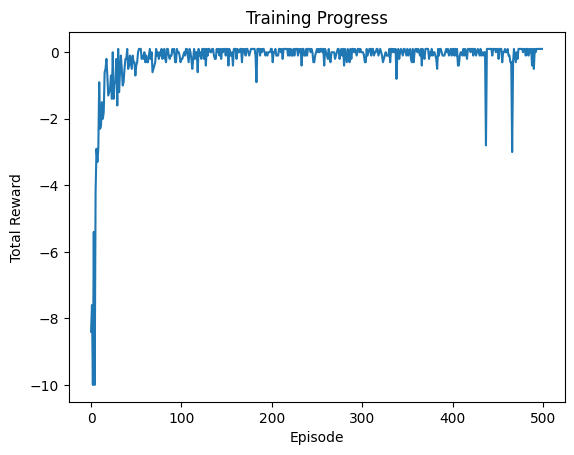

[-8.399999999999983,
 -7.599999999999985,
 -9.99999999999998,
 -5.399999999999993,
 -9.99999999999998,
 -4.1999999999999975,
 -2.900000000000002,
 -3.3000000000000007,
 -2.900000000000002,
 -0.9000000000000006,
 -2.3000000000000016,
 -2.2000000000000015,
 -1.5000000000000009,
 -2.0000000000000013,
 -1.8000000000000012,
 -0.6000000000000003,
 -0.5000000000000002,
 -0.19999999999999996,
 -0.7000000000000004,
 -1.3000000000000007,
 -1.2000000000000006,
 -1.1000000000000005,
 -0.7000000000000004,
 -1.4000000000000008,
 1.1102230246251565e-16,
 -1.4000000000000008,
 -0.9000000000000006,
 -0.9000000000000006,
 -0.19999999999999996,
 -1.600000000000001,
 0.10000000000000009,
 -1.2000000000000006,
 -0.6000000000000003,
 -0.09999999999999987,
 -0.5000000000000002,
 -1.0000000000000004,
 -0.9000000000000006,
 -0.5000000000000002,
 -0.19999999999999996,
 -0.19999999999999996,
 0.10000000000000009,
 -0.5000000000000002,
 -0.40000000000000013,
 -0.09999999999999987,
 -0.30000000000000004,
 -0.50000

In [3]:
print("Training the agent...")
train_dqn(episodes=500, batch_size=64, model_path='dqn_model.weights.h5')


Evaluating the agent...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
<ipython-input-2-c8ecc4489373>:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gray', 4)


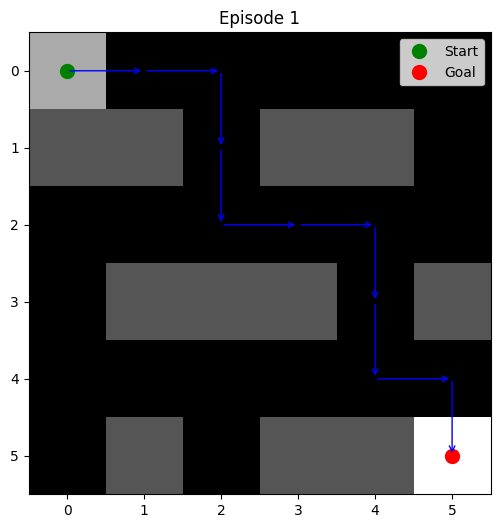


Episode 1:
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (4, 5), (5, 5)]
Path Length: 11
Total Reward: 0.10


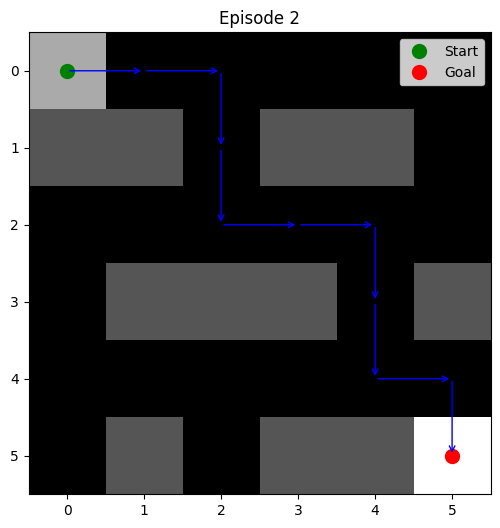


Episode 2:
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (4, 5), (5, 5)]
Path Length: 11
Total Reward: 0.10


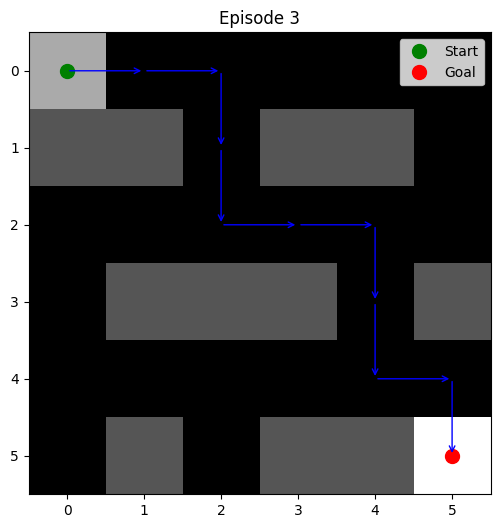


Episode 3:
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (4, 5), (5, 5)]
Path Length: 11
Total Reward: 0.10


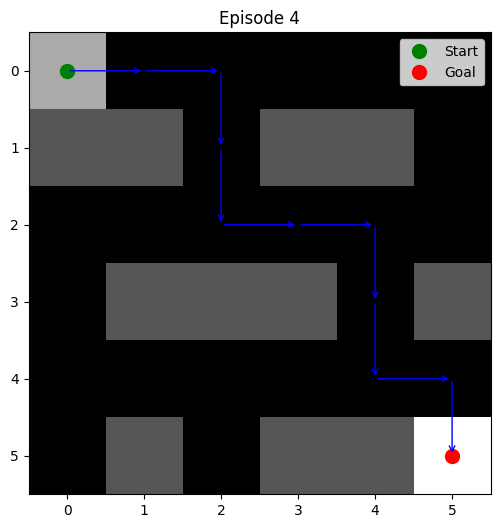


Episode 4:
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (4, 5), (5, 5)]
Path Length: 11
Total Reward: 0.10


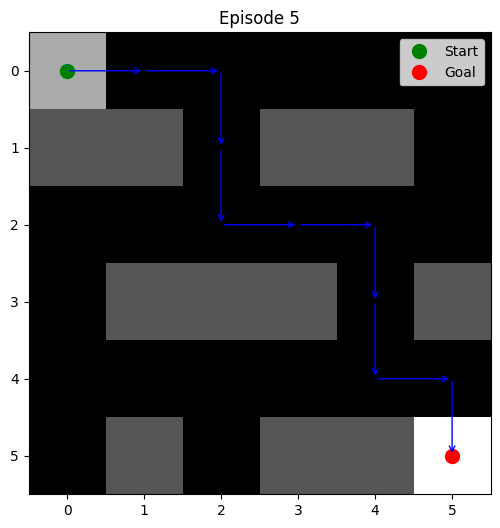


Episode 5:
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (4, 5), (5, 5)]
Path Length: 11
Total Reward: 0.10


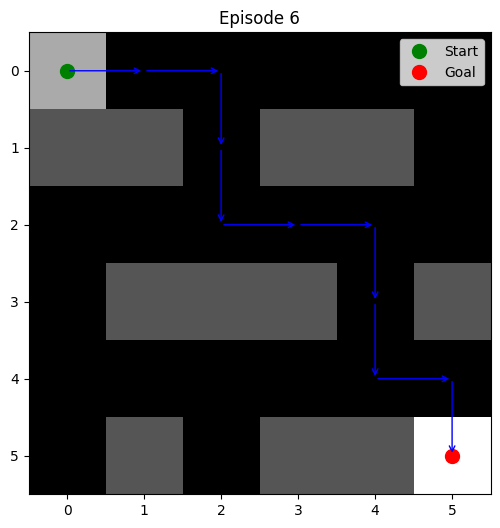


Episode 6:
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (4, 5), (5, 5)]
Path Length: 11
Total Reward: 0.10


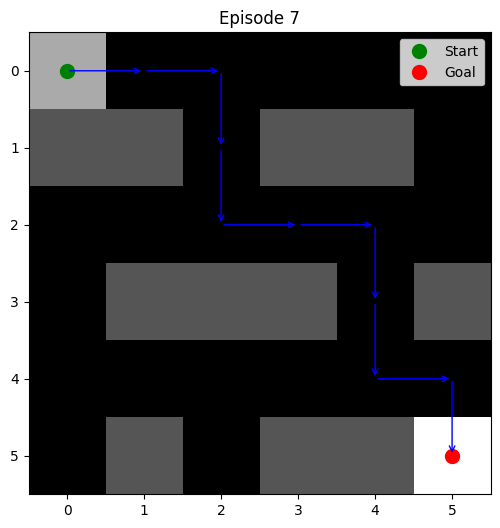


Episode 7:
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (4, 5), (5, 5)]
Path Length: 11
Total Reward: 0.10


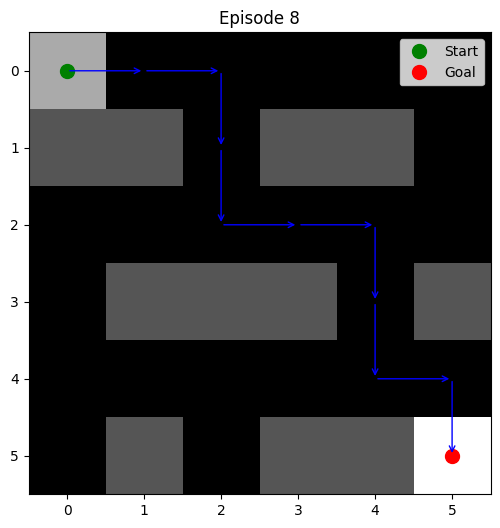


Episode 8:
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (4, 5), (5, 5)]
Path Length: 11
Total Reward: 0.10


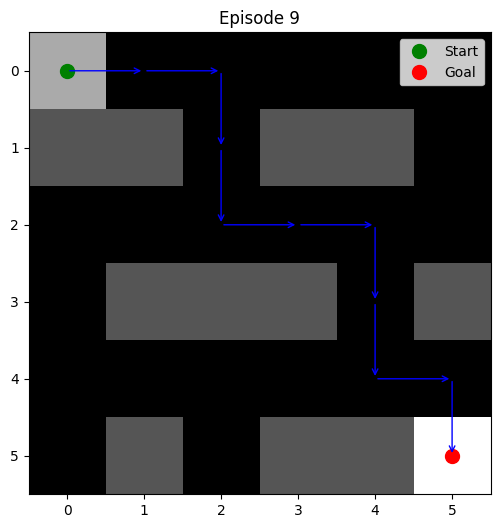


Episode 9:
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (4, 5), (5, 5)]
Path Length: 11
Total Reward: 0.10


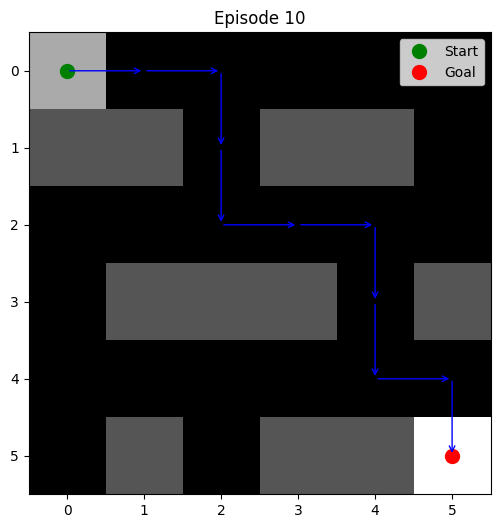


Episode 10:
Path: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (4, 5), (5, 5)]
Path Length: 11
Total Reward: 0.10


In [4]:
print("\nEvaluating the agent...")
evaluate_dqn(model_path='dqn_model.weights.h5')